In [1]:
import sys
sys.path.append('/Users/Brandon1')
from pythonimports import *
%matplotlib inline

In [2]:
#set this directory for health data and outfiles
DIR = '/Users/Brandon1/Desktop/apple_health_export/'

In [5]:
healthdata = open(op.join(DIR,'export.xml'),'rb')
d = healthdata.readlines()

In [6]:
len(d)

361253

In [ ]:
#each health source starts with 'HKQuantityTypeIdentifier' e.g., 'HKQuantityTypeIdentifierHeartRate

In [7]:
#info available for each source - some info == "NA"
srckeys = ['sourceName',
           'sourceVersion',
           'device',
           'unit',
           'creationDate',
           'creationDate_time',
           'startDate',
           'startDate_time',
           'endDate',
           'endDate_time',
           'value']

In [8]:
sp = " "
data = OrderedDict()
lcount = 0
srcrecs = OrderedDict()
for line in d[84:]:
    lcount += 1
    if line.startswith(" <R"):
        splits = line.split("<")[1].split("/>")[0].split("\" ")
        
        rtype,src = splits[0].split("=\"")
        src = "_".join([word for word in "".join([sp+x if x.isupper() else x for x in src[24:]]).split()])
        if not src in data.keys():
            data[src] = OrderedDict()
        data[src][lcount] = OrderedDict()
        
        for k in srckeys:
            data[src][lcount][k] = "NA"

        for split in splits[1:]:
            rec,val = split.split("=\"")
            try:
                assert rec in data[src][lcount].keys()
            except AssertionError:
                print "crap"
            if rec in ['startDate','endDate','creationDate']:
                date,time,whoknows = val.split(" ")
                data[src][lcount][rec] = date
                data[src][lcount]["%s_time" % rec] = time
            elif rec == 'device':
                dev = [v for v in val.split(", ") if 'name' in v][0].split(":")[1]
                data[src][lcount][rec] = dev
            elif rec == 'value':
                data[src][lcount][rec] = val[:-1]
            else:
                data[src][lcount][rec] = val
    if lcount % 10000 == 0:
        print lcount

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000


# write out the files

In [9]:
for src in sorted(data):
    filE = op.join(DIR,'%s.txt' % src)
    print filE
    with open(filE,'wb') as o:
        k0 = data[src].keys()[0]
        text = '\t'.join([k for k in data[src][k0].keys()]) + '\n'
        o.write("%s" % text)
        for lcount in data[src]:
            text = '\t'.join([k for k in data[src][lcount].values()]) + '\n'
            o.write("%s" % text)

/Users/Brandon1/Desktop/apple_health_export/Active_Energy_Burned.txt
/Users/Brandon1/Desktop/apple_health_export/Apple_Exercise_Time.txt
/Users/Brandon1/Desktop/apple_health_export/Apple_Stand_Hour.txt
/Users/Brandon1/Desktop/apple_health_export/Basal_Energy_Burned.txt
/Users/Brandon1/Desktop/apple_health_export/Distance_Walking_Running.txt
/Users/Brandon1/Desktop/apple_health_export/Flights_Climbed.txt
/Users/Brandon1/Desktop/apple_health_export/Heart_Rate.txt
/Users/Brandon1/Desktop/apple_health_export/Mindful_Session.txt
/Users/Brandon1/Desktop/apple_health_export/Sexual_Activity.txt
/Users/Brandon1/Desktop/apple_health_export/Sleep_Analysis.txt
/Users/Brandon1/Desktop/apple_health_export/Step_Count.txt


# check out the heart rate data

In [10]:
hr = pd.read_csv(op.join(DIR,'Heart_Rate.txt'),sep='\t')
hr.head()

,sourceName,sourceVersion,device,unit,creationDate,creationDate_time,startDate,startDate_time,endDate,endDate_time,value
0,Brandon’s Apple Watch,3.0,Apple Watch,count/min,2016-09-27,12:42:46,2016-09-27,12:39:24,2016-09-27,12:39:24,101
1,Brandon’s Apple Watch,3.0,Apple Watch,count/min,2016-09-27,12:48:36,2016-09-27,12:45:06,2016-09-27,12:45:06,102
2,Brandon’s Apple Watch,3.0,Apple Watch,count/min,2016-09-27,12:52:52,2016-09-27,12:51:16,2016-09-27,12:51:16,112
3,Brandon’s Apple Watch,3.0,Apple Watch,count/min,2016-09-27,12:57:45,2016-09-27,12:53:53,2016-09-27,12:53:53,112
4,Brandon’s Apple Watch,3.0,Apple Watch,count/min,2016-09-27,13:02:59,2016-09-27,13:02:48,2016-09-27,13:02:48,85


In [11]:
#get heart rate values into 10min bins, save dict
rate = OrderedDict()
for row in hr.index:
    ctime = ":".join([x for x in hr.loc[row,'creationDate_time'].split(":")[:-1]])[:-1]
    if not ctime in rate:
        rate[ctime] = []
    rate[ctime].append(hr.loc[row,'value'])
filE = op.join(DIR,'heart_rate_10mins.pkl')
with open(filE,'wb') as o:
    pickle.dump(rate,o,pickle.HIGHEST_PROTOCOL)

In [3]:
filE = op.join(DIR,'heart_rate_10mins.pkl')
rate = pickle.load(open(filE,'rb'))

/Users/Brandon1/anaconda/lib/python2.7/site-packages/pandas/tseries/base.py:361: FutureWarning: using '+' to provide set union with datetimelike Indexes is deprecated, use .union()
  "use .union()",FutureWarning)


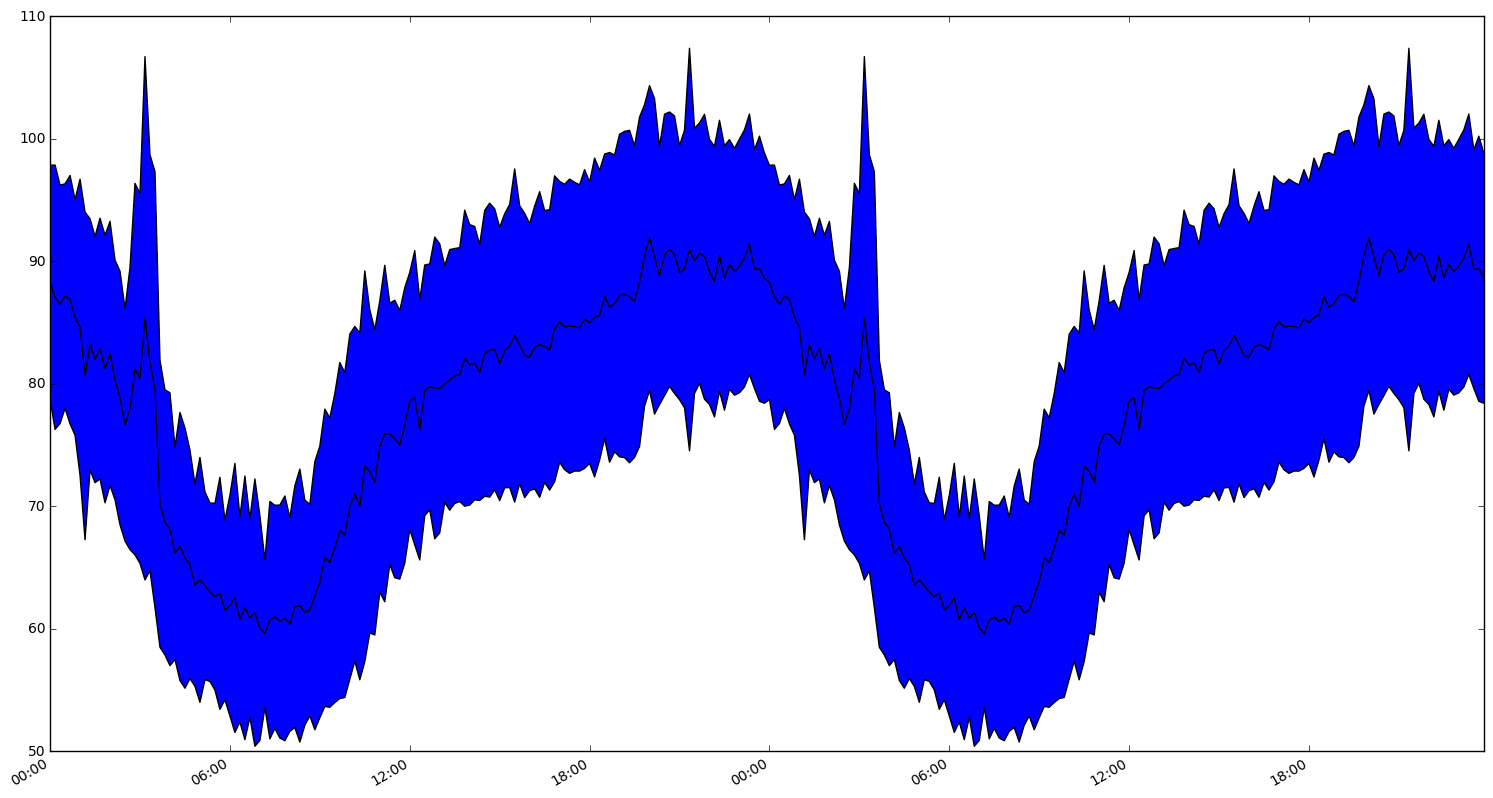

In [4]:
#make a fig with average heart rate per bin, and cloud of std (2 periods for continuity)
x = pd.date_range('2017-05-10',periods=288,freq='10min')+pd.date_range('2017-05-10',periods=144,freq='10min')
y = [np.mean([t for t in rate[time]]) for time in sorted(rate)]+[np.mean([t for t in rate[time]]) for time in sorted(rate)]
error = [np.std([t for t in rate[time]]) for time in sorted(rate)]+[np.std([t for t in rate[time]]) for time in sorted(rate)]
ymin = []
ymax = []
for i,Y in enumerate(y):
    ymin.append(y[i]-error[i])
    ymax.append(y[i]+error[i])

fig, ax = plt.subplots(1)
fig.autofmt_xdate()
fig.set_size_inches(18.5, 10.5)
pl.plot(x,y,'k-')
pl.fill_between(x,ymin,ymax)
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)

plt.show()

In [1]:
1+1

2